# Calculating trainsition states - part 1

Identifying the most compute effective approach to calculating transition states can be difficult. Let us guide you through the options in this short notebook. **Pre-requisite: Familiarity with ASE**

Breakdown of this tutorial:
I.) Creating a work case
II.) Methods with examples
III.) Common problems and how to solve them

First, let us create a toy model of Au FCC(111) surface and 2 Cu ad atoms. 

In [1]:
from examples.data.model_gen import get_example_slab
slab_initial = get_example_slab(adsorbate=True, type="2Cu")

In the model above the two Cu atoms are situated on top of hcp adsorption sites. The final geometry will be with copper atoms placed in non-neighbouring fcc and hcp sites. The goal is to calculate the transition state between the two and an activation energy.

In [2]:
slab_final = get_example_slab(adsorbate=True, type="2Cu")
hcp_position = [slab_final[1].x, (slab_final[15].y + slab_final[1].y)/2]
# place the copper atom in the position specified above
slab_final[19].x, slab_final[19].y = hcp_position[0], hcp_position[1]

Now before we proceed we need to make sure the structures are optimised. Forces convergence criterion is usually below 0.01 eV/Angstrom on each individual atom, but for the purposes of this tutorial a looser 0.05 value is used.

In [3]:
from ase.optimize import FIRE
from ase.constraints import FixAtoms
# For the purpose of this tutorial a  constraint is set for all of the surface atoms
# Constraints used should always be specific to your system and applied following tests
freeze = FixAtoms([atom.index for atom in slab_initial if atom.tag > 0])
slab_initial.set_constraint(freeze)
slab_final.set_constraint(freeze)

opt = FIRE(slab_initial, trajectory="slab_initial.traj")
opt.run(fmax=0.05)
opt = FIRE(slab_final, trajectory="slab_final.traj")
opt.run(fmax=0.05)

# You can have a look at the model using the visualizer
from ase.visualize import view
view(slab_initial, viewer='x3d')
view(slab_final, viewer='x3d')

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:31:20        9.933133*       1.8648
FIRE:    1 12:31:20        9.863088*       1.9071
FIRE:    2 12:31:21        9.716788*       1.9858
FIRE:    3 12:31:21        9.483704*       2.0742
FIRE:    4 12:31:21        9.158878*       2.0677
FIRE:    5 12:31:21        8.784932*       1.6238
FIRE:    6 12:31:21        8.574444*       0.7763
FIRE:    7 12:31:21        8.571462*       0.7632
FIRE:    8 12:31:21        8.565693*       0.7411
FIRE:    9 12:31:21        8.557447*       0.7173
FIRE:   10 12:31:21        8.547026*       0.6996
FIRE:   11 12:31:21        8.534591*       0.6938
FIRE:   12 12:31:21        8.520085*       0.7011
FIRE:   13 12:31:21        8.503243*       0.7180
FIRE:   14 12:31:21        8.481404*       0.7417
FIRE:   15 12:31:21        8.452719*       0.7676
FIRE:   16 12:31:21        8.414779*       0.7921
FIRE:   17 12:31:21        8.364598*       0.8158
FI

Now that we have the structures prepared, we need to look for an activation energy for transition between slab_initial and slab_final.

There are multiple ways one can approach this problem, but all will in the end help to establish highest energy geometry linking these two structures - the transition state.

    a.) NEB
    b.) MLNEB
    c.) AutoNEB
    d.) Surface diffusion energy barriers using ASE constraints - fixed plane
    e.) Surface diffusion energy barriers using ASE constraints - fixed bond lengths
    f.) Others not included in this tutorial - Dimer Method (and Improved Dimer Method), Growing String etc.

a.) Nudged Elastic Band - NEB

"The Nudged Elastic Band method is a technique for finding transition paths (and corresponding energy barriers) between given initial and final states. The method involves constructing a “chain” of “replicas” or “images” of the system and relaxing them in a certain way."

Detailed description of the NEB class as implemented in ASE, including useful publications:
https://wiki.fysik.dtu.dk/ase/ase/neb.html?highlight=neb#module-ase.neb
ASE take on this tutorial, exploring the functionality a bit more:
https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html

The "classic" NEB is a bit of a brute force approach. It takes a lot of trial and error to get below convergence criteria and it is costly. All of the "images" mentioned above are optimised per iteration, so if one is interested in getting to know the Minimum Energy Path (MEP) better, often number of DFT calculations goes into thousands.

One of the problems associated with NEBs in general is that they rely heavily on the user-provided input structures. If they are not optimal due to complexity of the process, the MEP is elongated and the overall experiment becomes more expensive. There are ways of improving initial/final guesses, but not as straightforward with regular NEB.

To overcome the complexity of the energy landscape we need to focus solely on the highest energy transition state and ignore the lesser maxima, which can arise due to rotations etc. For this we use a *climbing image* calculation (see NEB wiki for more info).

In [4]:
# a) NEB code in ASE
from ase.neb import NEB
from ase.calculators.emt import EMT
import copy

# Make a band consisting of 7 images (including initial and final)
# Very important - each image has to have a separate calculator!
# If one wants to use a single calculator, e.g. sockets with FHI-aims,
# the SingleCalculatorNEB class needs to be used in instead

images = [slab_initial]
images += [slab_initial.copy() for i in range(5)]
images += [slab_final]
neb = NEB(images, climb=True) # use climbing image calculation

# Interpolate linearly the potisions of the three middle images:
neb.interpolate()

# Set calculators:
for image in images[1:6]:
    image.set_calculator(EMT())

# Optimize:
optimizer = FIRE(neb,
                 trajectory='A2B.traj')
optimizer.run(fmax=0.05)

# Use ASE GUI to view the MEP. Only works on local PC
# view(images)


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:24:38        7.457057*       0.8594
FIRE:    1 12:24:38        7.450242*       0.7682
FIRE:    2 12:24:38        7.439444*       0.6028
FIRE:    3 12:24:38        7.428909*       0.3926
FIRE:    4 12:24:38        7.422364*       0.1778
FIRE:    5 12:24:39        7.421590*       0.1164
FIRE:    6 12:24:39        7.421588*       0.1154
FIRE:    7 12:24:39        7.421584*       0.1132
FIRE:    8 12:24:39        7.421580*       0.1101
FIRE:    9 12:24:39        7.421580*       0.1062
FIRE:   10 12:24:39        7.421587*       0.1016
FIRE:   11 12:24:40        7.421606*       0.0965
FIRE:   12 12:24:40        7.421640*       0.0913
FIRE:   13 12:24:40        7.421699*       0.0857
FIRE:   14 12:24:40        7.421796*       0.0802
FIRE:   15 12:24:40        7.421942*       0.0753
FIRE:   16 12:24:41        7.422150*       0.0717
FIRE:   17 12:24:41        7.422426*       0.0695
FI

True

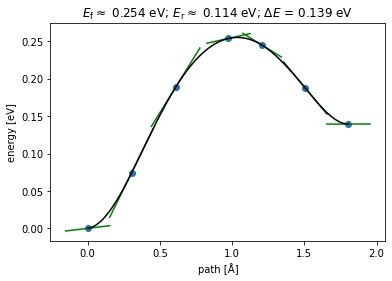

In [5]:
# Now let's analyse the output, if dealing with one calculation it is sufficient to use
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools

nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('barrier-neb.png')